## Import modules

In [1]:
import os
import sys
import math
from collections import OrderedDict
import copy
import random
import glob
from easydict import EasyDict
from typing import Dict, List
import time
os.chdir('/home/yuanyu/projects/rush')

import cv2
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.nn.init as init
import torch.utils.data as data
import torch.utils.data.dataset as dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score
import torchvision.utils as v_utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from skimage import exposure, img_as_float

from models.MNAD.model.utils import CustomDataLoader
from models.MNAD.model.final_future_prediction_with_memory_spatial_sumonly_weight_ranking_top1 import *
from models.MNAD.model.Reconstruction import *
from models.MNAD.utils import *
import urls

## 1 Set configs and environment

In [2]:
id = 31
cfg = EasyDict(
    # dataset
    video_folder='/home/yuanyu/projects/data/DaYanTa_2/8_C' + str(id) + '/frames_select',
    label_file_path='/home/yuanyu/projects/rush/process_xian_video_for_VAD/label_dyt_' + str(id) + '_0429.csv',
    transform=transforms.Compose([transforms.ToTensor()]),
    resized_height=256,
    resized_width=256,
    time_step=4,
    num_pred=1,

    # model
    method='pred',
    t_length=5,
    fdim=512,
    mdim=512,
    msize=10,

    # test
    model_path='./models/MNAD/exp/Xian/pred/log' + str(id) + '/model.pth',
    m_items_path='./models/MNAD/exp/Xian/pred/log' + str(id) + '/keys.pt',
    log_dir='./xian_results/' + str(id),
    gpus='1,2,3',
    batch_size=1,
    num_workers=1,

    alpha=1,
    th=0.01,
    loss_func_mse=nn.MSELoss(reduction='none'),
)

if not os.path.exists(cfg.log_dir):
    os.mkdir(cfg.log_dir)

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = cfg.gpus
# make sure to use cudnn for computational performance
torch.backends.cudnn.enabled = True

## 2 Load the dataset and model

In [4]:
# init dataloader
test_dataset = CustomDataLoader(cfg.video_folder, transforms.Compose([
    transforms.ToTensor(),
]), label_file_path=cfg.label_file_path,
    resize_height=cfg.resized_height, resize_width=cfg.resized_width, time_step=cfg.t_length-1, train=False)

test_loader = data.DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, drop_last=False)

0 3


In [5]:
# init model
model = torch.load(cfg.model_path)
model.cuda()
model.eval()
m_items = torch.load(cfg.m_items_path)

In [6]:
# log and test data_loader
print(len(test_loader))
for data in test_loader:
    print(type(data), data.shape)
    break

2235
<class 'torch.Tensor'> torch.Size([1, 15, 256, 256])


In [7]:
# log and test model
for imgs in test_loader:
    imgs = imgs.cuda()
    outputs, feas, updated_feas, m_items, softmax_score_query, softmax_score_memory, _, _, _, compactness_loss = model.forward(
        imgs[:, 0:3*4], m_items, False
    )
    mse_imgs = cfg.loss_func_mse((outputs[0]+1)/2, (imgs[0, 3*4:]+1)/2)
    mse_loss = torch.mean(mse_imgs).item()
    mse_feas = compactness_loss.item()
    
    print(mse_loss)
    break

0.00010850309627130628


## 3 Run the model on dataloader, and save results

In [8]:
# Init result savers
results = dict()

video_name_list = list()

mse_imgs_list = list()
mse_loss_list = list()
psnr_list = list()

In [9]:
for i, imgs in enumerate(test_loader):
    imgs = imgs.cuda()
    outputs, feas, updated_feas, m_items, softmax_score_query, softmax_score_memory, _, _, _, compactness_loss = model.forward(
        imgs[:, 0:3*4], m_items, False
    )
    mse_imgs = cfg.loss_func_mse((outputs[0]+1)/2, (imgs[0, 3*4:]+1)/2)
    mse_loss = torch.mean(mse_imgs).item()
    mse_feas = compactness_loss.item()
    psnr_ = psnr(mse_loss)

    print(i, mse_loss)
    torch.save({
        'mse_imgs': mse_imgs,
        'mse_loss': mse_loss,
        'psnr': psnr_
    }, f'{cfg.log_dir}/result_{i}.pt')

0 0.00010850309627130628
1 0.00014633155660703778
2 0.00010620945249684155
3 0.00012001337017863989
4 0.0001025547826429829
5 9.898144344333559e-05
6 0.00015705105033703148
7 0.00010808756633196026
8 0.00011005601845681667
9 0.0006200712523423135
10 0.0002015433128690347
11 0.00018328025180380791
12 0.00015749625163152814
13 0.00013465351366903633
14 0.00012814742513000965
15 0.00010945223039016128
16 0.0001463059161324054
17 0.00010861258488148451
18 0.00016336333646904677
19 0.00011582049046410248
20 0.00010362654575146735
21 9.66326188063249e-05
22 9.634437446948141e-05
23 0.00010302267037332058
24 9.79734759312123e-05
25 9.586833766661584e-05
26 0.00027048567426390946
27 0.00010810916865011677
28 0.00011319124314468354
29 0.00010736918193288147
30 0.00011068549065385014
31 0.0001000593401840888
32 0.00011094193905591965
33 9.457897249376401e-05
34 0.0005992903606966138
35 0.00027889045304618776
36 0.00017027136345859617
37 0.0001297059643547982
38 0.00012574472930282354
39 0.000109

316 0.00021540673333220184
317 0.00015218571934383363
318 0.00014328883844427764
319 0.00013536133337765932
320 0.0001328206853941083
321 0.00012804364087060094
322 0.000141662938403897
323 0.00013186623982619494
324 0.00012138685997342691
325 0.0001364895433653146
326 0.00012585447984747589
327 0.00023192008666228503
328 0.00015946640633046627
329 0.00011907776206498966
330 0.00012508936924859881
331 0.00012789925676770508
332 0.0001359763991786167
333 0.00011883323168149218
334 0.0006671913433820009
335 0.00023068707378115505
336 0.00019196749781258404
337 0.00016101781511679292
338 0.00014318060129880905
339 0.00012815302761737257
340 0.00021322246175259352
341 0.00016168733418453485
342 0.00014400287182070315
343 0.00013603804109152406
344 0.00013119803043082356
345 0.00013815371494274586
346 0.00015300993982236832
347 0.00014216465933714062
348 0.00013948645209893584
349 0.00012448205961845815
350 0.00011606403131736442
351 0.00011401402298361063
352 0.00021485860634129494
353 0.0

626 0.0001929486752487719
627 0.00016200420213863254
628 0.0002581356675364077
629 0.00014371416182257235
630 0.00015067742788232863
631 0.0001476224570069462
632 0.00013817354920320213
633 0.00013548159040510654
634 0.000686660292558372
635 0.00033227150561288
636 0.00022181989334058017
637 0.00019618395890574902
638 0.0002343715459574014
639 0.00019220501417294145
640 0.00020548701286315918
641 0.00021748023573309183
642 0.0001906010293168947
643 0.00019109707500319928
644 0.00017669661610852927
645 0.0001764774788171053
646 0.000166282057762146
647 0.00016826034698169678
648 0.00016327202320098877
649 0.00016644070274196565
650 0.0001768440706655383
651 0.0001935019827215001
652 0.0001777278957888484
653 0.00028272351482883096
654 0.00017525206203572452
655 0.00017608636699151248
656 0.00019122831872664392
657 0.00015768730372656137
658 0.00015535048441961408
659 0.0007132942555472255
660 0.000254705548286438
661 0.00025026476942002773
662 0.0002378796343691647
663 0.000193607003893

938 0.00015873175289016217
939 0.00013707848847843707
940 0.0001556796341901645
941 0.0001374713028781116
942 0.00020959344692528248
943 0.0001720492000458762
944 0.00014814377937000245
945 0.00014314234431367368
946 0.00013562312233261764
947 0.00013930563000030816
948 0.0001365338684991002
949 0.00014510785695165396
950 0.00016076989413704723
951 0.00014188973000273108
952 0.00013873061107005924
953 0.00013208217569626868
954 0.0006560742622241378
955 0.0002889535389840603
956 0.00021237139299046248
957 0.00016627080913167447
958 0.00016272449283860624
959 0.0001825328217819333
960 0.0001884460507426411
961 0.00017957910313270986
962 0.00014446841669268906
963 0.00015426763275172561
964 0.00016049215628299862
965 0.00015596384764648974
966 0.00015126142534427345
967 0.00024976645363494754
968 0.00016038799367379397
969 0.00015540535969194025
970 0.00016910649719648063
971 0.00015685413382016122
972 0.00015210805577225983
973 0.00016184040578082204
974 0.00016792274254839867
975 0.000

1240 0.00020209979265928268
1241 0.00014528280007652938
1242 0.00016716320533305407
1243 0.00018091258243657649
1244 0.00013780908193439245
1245 0.00015216768952086568
1246 0.00013904619845561683
1247 0.0001466897374484688
1248 0.0001332464162260294
1249 0.0001742937893141061
1250 0.00013367757492233068
1251 0.0002017875958699733
1252 0.0001328738289885223
1253 0.00012187047104816884
1254 0.0006738944794051349
1255 0.0002364105312153697
1256 0.00021083220781292766
1257 0.0001566451828693971
1258 0.00018067104974761605
1259 0.00016748890629969537
1260 0.00014513258065562695
1261 0.00018590709078125656
1262 0.00014467549044638872
1263 0.00019869043899234384
1264 0.00013839005259796977
1265 0.00015106715727597475
1266 0.00013625342398881912
1267 0.00012567290104925632
1268 0.0002785411197692156
1269 0.00012958343722857535
1270 0.0001362829643767327
1271 0.00013607769506052136
1272 0.00013627766747958958
1273 0.00013889226829633117
1274 0.00014389125863090158
1275 0.00016413780394941568
12

1543 0.00015584181528538465
1544 0.00018812557391356677
1545 0.00014212357928045094
1546 0.00014166701294016093
1547 0.00015341963444370776
1548 0.00013472881983034313
1549 0.00013792276149615645
1550 0.00012735676136799157
1551 0.00013645026774611324
1552 0.00013096652401145548
1553 0.00012620002962648869
1554 0.0001497344346717
1555 0.00014730959082953632
1556 0.0008572172373533249
1557 0.00023343064822256565
1558 0.000257935345871374
1559 0.0001840684999478981
1560 0.00017071038018912077
1561 0.0001405226648785174
1562 0.00022785829787608236
1563 0.00014342975919134915
1564 0.00015795670333318412
1565 0.00014003616524860263
1566 0.00012848444748669863
1567 0.00014946894953027368
1568 0.0001778184960130602
1569 0.00015043275197967887
1570 0.00014188412751536816
1571 0.00012834483641199768
1572 0.00014884451229590923
1573 0.00013011104601901025
1574 0.00015578127931803465
1575 0.00013881029735784978
1576 0.00013006312656216323
1577 0.0001331855310127139
1578 0.0001336015557171777
1579

1841 0.00014742313942406327
1842 0.0002054958458757028
1843 0.00014566772733815014
1844 0.00015395850641652942
1845 0.00015191189595498145
1846 0.00014522041601594537
1847 0.0001563426194479689
1848 0.00015315759810619056
1849 0.0001457336766179651
1850 0.00014065422874409705
1851 0.0001466919929953292
1852 0.000144780904520303
1853 0.0001588320010341704
1854 0.00018120594904758036
1855 0.00014206438208930194
1856 0.0007423635106533766
1857 0.00026087879086844623
1858 0.00019855661957990378
1859 0.00019080995116382837
1860 0.0001718970452202484
1861 0.00019300733401905745
1862 0.00019705662271007895
1863 0.0001892585860332474
1864 0.00026166028692387044
1865 0.00017543751164339483
1866 0.00021312553144525737
1867 0.0001712383673293516
1868 0.00018658720364328474
1869 0.0001916186884045601
1870 0.00019534106831997633
1871 0.0001896004832815379
1872 0.00017492636106908321
1873 0.0001875740708783269
1874 0.00018686449038796127
1875 0.00014913780614733696
1876 0.00017790599667932838
1877 0

2143 0.0003147899988107383
2144 0.0003018934221472591
2145 0.0003699520602822304
2146 0.0003976251173298806
2147 0.0003468553477432579
2148 0.00027855896041728556
2149 0.0003186846151947975
2150 0.0003142470959573984
2151 0.000409911444876343
2152 0.0004320318694226444
2153 0.00033677835017442703
2154 0.00033265375532209873
2155 0.0003924761840607971
2156 0.0010332209058105946
2157 0.000486218836158514
2158 0.00044789371895603836
2159 0.00039930883212946355
2160 0.00033897272078320384
2161 0.00030433604842983186
2162 0.0003183800436090678
2163 0.0003451035590842366
2164 0.0004264905583113432
2165 0.00044795533176511526
2166 0.0004265847965143621
2167 0.0004937321646139026
2168 0.0004477579495869577
2169 0.00042874214705079794
2170 0.00040341014391742647
2171 0.0003784055297728628
2172 0.000394498638343066
2173 0.0003298113006167114
2174 0.00033545875339768827
2175 0.00037277437513694167
2176 0.0003742273838724941
2177 0.0003861742443405092
2178 0.0003938148729503155
2179 0.000400230957

## 4 match results with video_name

In [10]:
samples = test_dataset.samples
print(len(samples), samples[0])
# print(samples)

2235 /home/yuanyu/projects/data/DaYanTa_2/8_C31/frames_select/2021-04-29_20-38-42_014/img_00001.jpg


In [11]:
result_dict = dict()

for i, frame_path in enumerate(samples):
    video_name = frame_path.split('/')[-2]
    frame_name = frame_path.split('/')[-1].split('.')[-2]

    if result_dict.get(video_name, None) is None:
        result_dict[video_name] = list()
    result_dict[video_name].append(
        (frame_path, i)
    )

torch.save(result_dict, f'{cfg.log_dir}/result_dict.pt')

## 5 Evaluate results

In [16]:
result_dict = torch.load(f'{cfg.log_dir}/result_dict.pt')
# print(result_dict)
label_df = pd.read_csv(cfg.label_file_path, index_col=3)

In [17]:
label_df.tail()

,Unnamed: 0,district,date,start_frame,end_frame,anomaly
new_video,,,,,,
2021-04-29_21-15-08_098,8997,台西换乘楼梯31,429,-1,-1,逆行
2021-04-29_21-15-08_099,8998,台西换乘楼梯31,429,-1,-1,逆行
2021-04-29_20-38-42_014,8999,台西换乘楼梯31,429,-1,-1,逆行
2021-04-29_20-38-42_035,9000,台西换乘楼梯31,429,-1,-1,逆行
2021-04-29_21-15-08_097,9001,台西换乘楼梯31,429,-1,-1,逆行跑动


In [13]:
# label_df
print(len(label_df))
print(len(result_dict))
# print(label_df.index)
count = 0
for video_name in label_df.index:
    if video_name not in result_dict.keys():
        count+=1
        print(video_name)
print(count)

9002
3
2021-04-29_18-31-39_8637
2021-04-29_18-31-39_020
2021-04-29_18-31-39_021
2021-04-29_18-31-39_022
2021-04-29_18-31-39_023
2021-04-29_18-31-39_024
2021-04-29_18-31-39_025
2021-04-29_18-31-39_026
2021-04-29_18-31-39_027
2021-04-29_18-31-39_028
2021-04-29_18-31-39_029
2021-04-29_18-31-39_030
2021-04-29_18-31-39_031
2021-04-29_18-31-39_032
2021-04-29_18-31-39_033
2021-04-29_18-31-39_034
2021-04-29_18-31-39_035
2021-04-29_18-31-39_036
2021-04-29_18-31-39_037
2021-04-29_18-31-39_038
2021-04-29_18-31-39_039
2021-04-29_18-31-39_040
2021-04-29_18-31-39_041
2021-04-29_18-31-39_042
2021-04-29_18-31-39_043
2021-04-29_18-31-39_044
2021-04-29_18-31-39_045
2021-04-29_18-31-39_046
2021-04-29_18-31-39_047
2021-04-29_18-31-39_048
2021-04-29_18-31-39_049
2021-04-29_18-31-39_050
2021-04-29_18-31-39_051
2021-04-29_18-31-39_052
2021-04-29_18-31-39_053
2021-04-29_18-31-39_054
2021-04-29_18-31-39_055
2021-04-29_18-31-39_056
2021-04-29_18-31-39_057
2021-04-29_18-31-39_058
2021-04-29_18-31-39_059
2021-04-

2021-04-29_18-31-39_3009
2021-04-29_18-31-39_3010
2021-04-29_18-31-39_3011
2021-04-29_18-31-39_3012
2021-04-29_18-31-39_3013
2021-04-29_18-31-39_3014
2021-04-29_18-31-39_3015
2021-04-29_18-31-39_3016
2021-04-29_18-31-39_3017
2021-04-29_18-31-39_3018
2021-04-29_18-31-39_3019
2021-04-29_18-31-39_3020
2021-04-29_18-31-39_3021
2021-04-29_18-31-39_3022
2021-04-29_18-31-39_3023
2021-04-29_18-31-39_3024
2021-04-29_18-31-39_3025
2021-04-29_18-31-39_3026
2021-04-29_18-31-39_3027
2021-04-29_18-31-39_3028
2021-04-29_18-31-39_3029
2021-04-29_18-31-39_3030
2021-04-29_18-31-39_3031
2021-04-29_18-31-39_3032
2021-04-29_18-31-39_3033
2021-04-29_18-31-39_3034
2021-04-29_18-31-39_3035
2021-04-29_18-31-39_3036
2021-04-29_18-31-39_3037
2021-04-29_18-31-39_3038
2021-04-29_18-31-39_3039
2021-04-29_18-31-39_3040
2021-04-29_18-31-39_3041
2021-04-29_18-31-39_3042
2021-04-29_18-31-39_3043
2021-04-29_18-31-39_3044
2021-04-29_18-31-39_3045
2021-04-29_18-31-39_3046
2021-04-29_18-31-39_3047
2021-04-29_18-31-39_3048


2021-04-29_18-31-39_5929
2021-04-29_18-31-39_5930
2021-04-29_18-31-39_5931
2021-04-29_18-31-39_5932
2021-04-29_18-31-39_5933
2021-04-29_18-31-39_5934
2021-04-29_18-31-39_5935
2021-04-29_18-31-39_5936
2021-04-29_18-31-39_5937
2021-04-29_18-31-39_5938
2021-04-29_18-31-39_5939
2021-04-29_18-31-39_5940
2021-04-29_18-31-39_5941
2021-04-29_18-31-39_5942
2021-04-29_18-31-39_5943
2021-04-29_18-31-39_5944
2021-04-29_18-31-39_5945
2021-04-29_18-31-39_5946
2021-04-29_18-31-39_5947
2021-04-29_18-31-39_5948
2021-04-29_18-31-39_5949
2021-04-29_18-31-39_5950
2021-04-29_18-31-39_5951
2021-04-29_18-31-39_5952
2021-04-29_18-31-39_5953
2021-04-29_18-31-39_5954
2021-04-29_18-31-39_5955
2021-04-29_18-31-39_5956
2021-04-29_18-31-39_5957
2021-04-29_18-31-39_5958
2021-04-29_18-31-39_5959
2021-04-29_18-31-39_5960
2021-04-29_18-31-39_5961
2021-04-29_18-31-39_5962
2021-04-29_18-31-39_5963
2021-04-29_18-31-39_5964
2021-04-29_18-31-39_5965
2021-04-29_18-31-39_5966
2021-04-29_18-31-39_5967
2021-04-29_18-31-39_5968


2021-04-29_20-56-56_040
2021-04-29_20-56-56_041
2021-04-29_20-56-56_042
2021-04-29_20-56-56_043
2021-04-29_20-56-56_042
2021-04-29_20-56-56_043
2021-04-29_20-56-56_044
2021-04-29_20-56-56_044
2021-04-29_20-56-56_046
2021-04-29_20-56-56_047
2021-04-29_20-56-56_049
2021-04-29_20-56-56_050
2021-04-29_20-56-56_049
2021-04-29_20-56-56_050
2021-04-29_20-56-56_049
2021-04-29_20-56-56_050
2021-04-29_20-56-56_062
2021-04-29_20-56-56_063
2021-04-29_20-56-56_063
2021-04-29_20-56-56_064
2021-04-29_20-56-56_064
2021-04-29_20-56-56_065
2021-04-29_20-56-56_065
2021-04-29_20-56-56_066
2021-04-29_20-56-56_075
2021-04-29_20-56-56_076
2021-04-29_20-56-56_076
2021-04-29_20-56-56_077
2021-04-29_20-56-56_078
2021-04-29_20-56-56_076
2021-04-29_20-56-56_077
2021-04-29_20-56-56_078
2021-04-29_20-56-56_077
2021-04-29_20-56-56_078
2021-04-29_20-56-56_079
2021-04-29_20-56-56_079
2021-04-29_20-56-56_080
2021-04-29_20-56-56_081
2021-04-29_20-56-56_079
2021-04-29_20-56-56_080
2021-04-29_20-56-56_081
2021-04-29_20-56

In [14]:
def show_one_result(result_dict: Dict[str, object], samples: List[str], idx: int):
    assert idx < len(samples)
    frame_path = samples[idx]
    video_name = frame_path.split('/')[-2]
    anomaly = label_df.loc[video_name, 'anomaly']
    print(video_name, anomaly)

    result = result_dict[video_name]

    psnr_list = list()
    mse_imgs = list()
    # anomaly_score_list_ = list()
    for _, i in result:
        # print(frame_path, i)
        
        # load raw frame

        # load mse_imgs, psnr
        result_i = torch.load(f'{cfg.log_dir}/result_{i}.pt')
        mse_img = result_i['mse_imgs'].permute(1, 2, 0).cpu().detach().numpy()
        psnr = result_i['psnr']

        mse_imgs.append(mse_img)
        psnr_list.append(psnr)
        # break
    # print(psnr_list)
    anomaly_score_list_ = anomaly_score_list_inv(psnr_list)
    fig = plt.figure()
    ims = []
    for i in range(len(anomaly_score_list_)):
        im = plt.plot(anomaly_score_list_[:i])
        plt.yticks(np.arange(0, 1.1, 0.1))
        ims.append(im)
    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    ani.save(str(id) + f"score_{video_name}.gif",writer='pillow')

    fig = plt.figure()
    plt.axis('off')
    ims = []
    for i in range(len(mse_imgs)):
        img = mse_imgs[i]
        img = 1-exposure.rescale_intensity(img)
        im = plt.imshow(img, animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    ani.save(str(id) + f"mse_{video_name}.gif",writer='pillow')
    # plt.show()
    # print(anomaly_score_list_)
    

2021-04-29_20-38-42_014 逆行


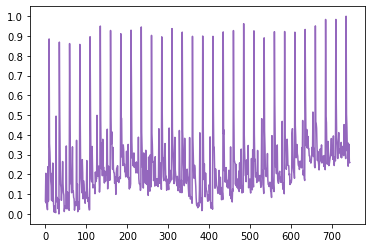

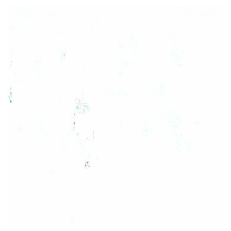

In [18]:
# for i in range(3):
show_one_result(result_dict, samples, 100)
# input()
# break